# Step-by-Step Implementation of MC Simulations of Gas-Liquid Transitions & Phase Equilibria


In [ ]:
# Import necessary libraries
import numpy as np
import time
import matplotlib.pyplot as plt

# Initialization of the positions & PBCs

In [ ]:
# Set a seed for reproducibility
#np.random.seed(42)

# Function to initialize particle positions in a cubic box with side length L
def initialize_positions(N, L):
  """
  This function generates random positions for N particles inside a cubic box of length L
  The positions are uniformly distributed in the interval [-L/2, L/2).
  """
  return (np.random.rand(N, 3) - 0.5) * L

# Apply periodic boundary conditions
def apply_pbc(dx, dy, dz, L):
  """
  This function applies periodic boundary conditions by wrapping particle coordinates within the box.
  """
  dx -= L * np.round(dx / L)
  dy -= L * np.round(dy / L)
  dz -= L * np.round(dz / L)
  return dx, dy, dz

# Total Energy & Energy for 1 Particle

In [ ]:
# Calculate the total energy of the system using the Lennard-Jones potential
def total_energy(positions, L, epsilon, sigma):
  """
  Computes the total repulsion and attraction energies of the system
  using L-J potential for every pair of particles.
  """
  # Extracting the no of molecules from positions matrix
  N = positions.shape[0]
  repulsion_energy = 0
  attraction_energy = 0

  # Precompute constant 4 * epsilon
  const_4epsilon = 4 * epsilon

  # Iterates over all particles
  for i in range(N-1):
      # Compute the displacement vectors with all other particles
      dx = positions[i, 0] - positions[i+1:, 0]
      dy = positions[i, 1] - positions[i+1:, 1]
      dz = positions[i, 2] - positions[i+1:, 2]

       # Apply PBCs
      dx, dy, dz = apply_pbc(dx, dy, dz, L)

      # Compute the squared distance (r^2)
      r2 = dx**2 + dy**2 + dz**2

      # Compute (sigma^2 / r^2) = sigma^2 / r2
      inv_r2 = (sigma**2) / r2

      # Compute r^6 &  r^12
      r6 = inv_r2**3
      r12 = r6**2

      # Compute the repulsion and attraction energies separately
      repulsion_energy += np.sum(const_4epsilon * r12)
      attraction_energy += np.sum(-const_4epsilon * r6)

  return repulsion_energy, attraction_energy

# Calculate the energy contribution for a single particle with all others
def U_for_1_particle(positions, L, epsilon, sigma, identity):
  """
  Computes the repulsion and attraction energies for a single particle
  interatcing with all other particles.
  """
  N = positions.shape[0]
  repulsion_energy = 0
  attraction_energy = 0
  const_4epsilon = 4 * epsilon

  # Displacement of the particle with index "identity" from all other particles
  dx = positions[identity, 0] - positions[np.arange(N) != identity, 0]
  dy = positions[identity, 1] - positions[np.arange(N) != identity, 1]
  dz = positions[identity, 2] - positions[np.arange(N) != identity, 2]

  # Apply periodic boundary conditions
  dx, dy, dz = apply_pbc(dx, dy, dz, L)

  #  Compute the squared distance (r^2)
  r2 = dx**2 + dy**2 + dz**2

  # Compute (sigma^2 / r^2) = sigma^2 / r2
  inv_r2 = (sigma**2) / r2

  # Compute r^6 &  r^12
  r6 = inv_r2**3
  r12 = r6**2

  # Calculate repulsion and attraction energies separately
  repulsion_energy += np.sum(const_4epsilon * r12)
  attraction_energy += np.sum(-const_4epsilon * r6)

  # Return the energies separately
  return repulsion_energy, attraction_energy

# Particle Move & Volume Fluctuation

In [ ]:
# Monte Carlo particle move with Metropolis acceptance criterion
def mc_particle_move(positions, repulsion_energy, attraction_energy, L, epsilon, sigma, beta):
  """
  This function proposes a move of a random particle ith.
  The new position is accepted or rejected based on the energy change.
  """

  N = positions.shape[0]
  i = np.random.randint(N) # Select a random particle

  # Compute the current energy contribution of the ith particle, i here for identity
  current_repulsion_energy_i, current_attraction_energy_i = U_for_1_particle(positions, L, epsilon, sigma, i)

  # Propose a random move for the selected particle
  trial_positions = positions.copy()
  trial_positions[i] += (np.random.rand(3) - 0.5) * 0.1 # Small move (delta=0.1, magnitude of displacement)

  # Compute the new energy contribution of the moved particle
  new_repulsion_energy_i, new_attraction_energy_i = U_for_1_particle(trial_positions, L, epsilon, sigma, i)

  # Compute the energy differences
  delta_repulsion_E = new_repulsion_energy_i - current_repulsion_energy_i
  delta_attraction_E = new_attraction_energy_i - current_attraction_energy_i

  delta_E = delta_repulsion_E + delta_attraction_E  # Total energy difference

  # Metropolis acceptance criterion
  if delta_E < 0 or np.random.rand() < np.exp(-beta * delta_E):
      return trial_positions, repulsion_energy + delta_repulsion_E, attraction_energy + delta_attraction_E  # Accept move
  else:
      return positions, repulsion_energy, attraction_energy  # Reject move

# Monte Carlo volume move with Metropolis acceptance criterion
def mc_volume_move(positions, L, V, epsilon, sigma, betaP, repulsion_energy, attraction_energy):
  """
  This function proposes a change in the volume and resizes the system.
  The volume change is accepted or rejected based on the energy change and pressure.
  """
  N = positions.shape[0]

  # Propose a volume change
  delta_V = (np.random.rand() - 0.5) * 100  # N=1000
  #delta_V = (np.random.rand() - 0.5) * 10  # N=100
  #delta_V = (np.random.rand() - 0.5) * 1   # N=10

  # New volume after the proposed volume change
  new_V = V + delta_V

  # Check if the new volume is negative
  if new_V <= 0:
      print("Warning: Proposed negative volume. Rejecting the volume move.")
      return positions, L, V, repulsion_energy, attraction_energy  # Reject move, return old values

  # Re-calculation of the new box length
  new_L = new_V ** (1/3)

  # Rescale positions of particles to the new volume
  scale_factor = new_L / L
  trial_positions = positions * scale_factor

  # Ratio of old length to new length
  length_ratio_6 = (L / new_L) ** 6
  length_ratio_12 = length_ratio_6 ** 2

  # Calculate the change in attraction and repulsion energies
  delta_attraction_energy = attraction_energy * (length_ratio_6 - 1)
  delta_repulsion_energy = repulsion_energy * (length_ratio_12 - 1)

  # Total energy change
  delta_E = delta_attraction_energy + delta_repulsion_energy

  # Metropolis acceptance criterion
  if delta_E < 0 or np.random.rand() < np.exp(N * np.log(new_V/V) - delta_E - betaP * delta_V):
      # Update energies
      attraction_energy += delta_attraction_energy
      repulsion_energy += delta_repulsion_energy
      return trial_positions, new_L, new_V, repulsion_energy, attraction_energy # Accept the volume change
  else:
      return positions, L, V, repulsion_energy, attraction_energy  # Reject the volume change


# Radial Distribution Function

In [ ]:
def radial_distribution(positions, L, N, num_bins, delta_r, max_r_initial):
  """
  Compute the radial distribution function g(r) using the Ns vector approach.
  """

  # Initialize Ns vector to store counts
  Ns = np.zeros(num_bins)

  # Bin centers (r values)
  r_values = np.linspace(delta_r/2, int(max_r_initial/delta_r)-delta_r/2, num_bins)

  # Average density
  avg_density = N / (L**3)

  # Loop over each reference particle k
  for k in range(N):
    # Loop through i = 1 to k-1
    for i in range(1, k):
      # Compute the distance between particle k and i
      dx = positions[k, 0] - positions[i, 0]
      dy = positions[k, 1] - positions[i, 1]
      dz = positions[k, 2] - positions[i, 2]

      # Apply PBCs
      dx, dy, dz = apply_pbc(dx, dy, dz, L)

      # Compute r
      r = np.sqrt(dx**2 + dy**2 + dz**2)

      # Bin the distance and count if within max_r
      if r < max_r_initial:
        bin_index = int(r / delta_r)
        if bin_index < num_bins:
          Ns[bin_index] += 1

    # Loop through i = k+1 to N
    for i in range(k+1, N):
      # Compute the distance between particke k and i
      dx = positions[k, 0] - positions[i, 0]
      dy = positions[k, 1] - positions[i, 1]
      dz = positions[k, 2] - positions[i, 2]

      # Apply PBCs
      dx, dy, dz = apply_pbc(dx, dy, dz, L)

      # Compute r
      r = np.sqrt(dx**2 + dy**2 + dz**2)

      # Bin the distance and count if within max_r
      if r < max_r_initial:
        bin_index = int(r / delta_r)
        if bin_index < num_bins:
          Ns[bin_index] += 1


  # Normalize Ns to compute g(r)
  g_r = np.zeros(num_bins)
  for bin_index in range(num_bins):
    r = r_values[bin_index]
    # Compute volume of the spherical shell
    delta_V = (4 * np.pi / 3) * ((r + delta_r/2)**3 - (r - delta_r/2)**3)
    g_r[bin_index] = Ns[bin_index] / (avg_density * delta_V * N)

  return g_r

In [ ]:
def plot_radial_distribution(g_r_accumulated, delta_r, max_r_initial, num_bins):
  """
  Plot the radial distribution function g(r) as a function of r.
  """

  # Generate r values (bin centers)
  r_values = np.linspace(delta_r/2, int(max_r_initial/delta_r)-delta_r/2, num_bins)

  # Plot g(r) vs r
  plt.figure(figsize=(8, 6))
  plt.plot(r_values, g_r_accumulated, label='Radial Distribution Function g(r)', color='green')

  # Labels and title
  plt.xlabel('Distance r')
  plt.ylabel('g(r)')
  plt.title('Radial Distribution Function g(r)')
  plt.grid(True)
  plt.legend()

  # Show the plot
  plt.show()


# The Density Distribution Function

In [ ]:
def densities_and_average_volume(volumes, N):
  """
  Calculates the densities, plots the density distribution
  and computes the average of the inverse volume <1/V>.
  """

  # Calculate densities for each volume
  densities = [N/V for V in volumes] # Density = N/V

  # Calculate averages
  average_inverse_volume = np.mean([1/V for V in volumes])
  average_volume = np.mean(volumes)
  inverse_average_volume = 1 / average_volume

  # Print the comparison between <1/V> and 1/<V>
  print(f"<1/V>: {average_inverse_volume}")
  print(f"1/<V>: {inverse_average_volume}")

  return densities

# Run the simulations

In [ ]:
# NVT equilibration
def run_nvt_equilibration(steps, positions, L, epsilon, sigma, beta):
  """
  Perform NVT equilibration where volume is a constant, and only particle moves are allowed.
  """

  # Initialize the repulsion and attraction energies of the system
  repulsion_energy, attraction_energy = total_energy(positions, L, epsilon, sigma)

  # List to store total energy (repulsion + attraction) for plotting
  energy_values = []

  with open("NVT_Equilibration.txt", "w") as file:
      for step in range(steps):
          # Perform a Monte Carlo particle move and update the repulsion and attraction energies
          positions, repulsion_energy, attraction_energy = mc_particle_move(
              positions, repulsion_energy, attraction_energy, L, epsilon, sigma, beta)

          # Compute the total energy as the sum of repulsion and attraction energies
          total_energy_system = repulsion_energy + attraction_energy

          # Append the total energy to the list for plotting
          energy_values.append(total_energy_system)

          # Write the total energy to the file every 10,000 steps
          if step % 10000 == 0:
              file.write(f"Equilibration Step {step}, Total Energy: {total_energy_system}\n")

      file.write(f"Equilibration Step {step}, Total Energy: {total_energy_system}\n")

  return positions, repulsion_energy, attraction_energy, energy_values

In [ ]:
# NpT simulation with particle and volume moves
def run_simulation(steps, positions, L, V, epsilon, sigma, beta, betaP, repulsion_energy, attraction_energy, N):
  """
  Run NpT Monte Carlo simulation with particle and volume moves.
  Periodically checks energy conservation and computes the g(r).
  """

  volumes = []

  start_time = time.time() # Record the start time

  volumes.append(V) # Add the initial volume to the list

  energy_check_interval = steps // 10 # Perform the check 10 times during the simulation

  #  Initialize g_r_accumulated as zeros (accumulates over simulation)
  delta_r = 0.1  # Same delta_r as in the radial_distribution function
  max_r_initial = L / 2
  num_bins = int(max_r_initial / delta_r)
  g_r_accumulated = np.zeros(num_bins)

  with open("NPT_Simulation.txt", "w") as file:
    # Simulation loop
    for step in range(steps):

      # Perform a Monte Carlo particle move 90% of the time
      if np.random.rand() <= 0.9:
          positions, repulsion_energy, attraction_energy = mc_particle_move(
                positions, repulsion_energy, attraction_energy, L, epsilon, sigma, beta)

      # Perform a Monte Carlo volume move 10% of the time
      else:
          positions, L, V, repulsion_energy, attraction_energy = mc_volume_move(
              positions, L, V, epsilon, sigma, betaP, repulsion_energy, attraction_energy)

      # Store volume
      volumes.append(V)

      # Energy conservation check every energy_check_interval steps
      if step % energy_check_interval == 0 and step > 0:
          # Save the current energy state (before recalculation)
          saveU = repulsion_energy + attraction_energy

          # Recalculate the current energy from total_energy
          recalculated_repulsion_energy, recalculated_attraction_energy = total_energy(positions, L, epsilon, sigma)
          current_energy = recalculated_repulsion_energy + recalculated_attraction_energy

          # Calculate the relative difference
          relative_diff = abs((saveU - current_energy) / current_energy)

          # Log the relative difference to the file
          if relative_diff > 1e-11:
              print(f"Warning: Energy conservation check failed at step {step}. Relative difference: {relative_diff}\n")
          else:
              print(f"Energy conservation check passed at step {step}. Relative difference: {relative_diff}\n")

      # Every 10% of the simulation, update g_r_accumulated
      if step % (steps // 10) == 0:
        g_r_step = radial_distribution(positions, L, N, num_bins, delta_r, max_r_initial) # Calculate g(r) for the current step
        g_r_accumulated += g_r_step  # Accumulate g(r) over steps

      if step % 10000 == 0:
          elapsed_time = time.time() - start_time
          # Calculate the total energy (repulsion + attraction)
          total_energy_system = repulsion_energy + attraction_energy
          # Log step info with total energy
          print(f"Step {step}, Volume: {V}, Total Energy: {total_energy_system}, Time Elapsed: {elapsed_time:.2f} seconds")
          file.write(f"Step {step}, Volume: {V}, Total Energy: {total_energy_system}, Time Elapsed: {elapsed_time:.2f} seconds\n")

  # Normalize the accumulated g(r) after the simulation is finished
  g_r_accumulated /= (steps // 10)  # Divide by the number of updates

  # Plot the radial distribution
  plot_radial_distribution(g_r_accumulated, delta_r, max_r_initial, num_bins)

  return volumes, positions, repulsion_energy, attraction_energy


# Parameters


In [ ]:
# Parameters for initial gas and liquid simulations
sigma = 1.0

kB = 1  # Assuming reduced units

T_star = 1 / 1.05  # Reduced temperature

beta = 1 / (kB * T_star)

epsilon = 1.05

betaP = 0.023

# Gas Phase Simulation

In [ ]:
# Gas phase
N = 1000 # Number of particles
V = N / 0.027 # Gas phase
L = V ** (1/3)

In [ ]:
# Step 1: Initialize particle positions
positions = initialize_positions(N, L)

In [ ]:
# Step 2: Run NVT equilibration
equilibration_steps = 1000000  # Number of steps for NVT equilibration
positions, repulsion_energy, attraction_energy, energy_values_gas = run_nvt_equilibration(
    equilibration_steps, positions, L, epsilon, sigma, beta)

Step 0, Volume: 37037.03703703704, Total Energy: -244.17743614643229, Time Elapsed: 11.05 seconds
Step 10000, Volume: 38119.529110667456, Total Energy: -236.7720832754926, Time Elapsed: 13.42 seconds
Step 20000, Volume: 37474.3756519896, Total Energy: -245.92622850993502, Time Elapsed: 15.80 seconds
Step 30000, Volume: 36674.537208407426, Total Energy: -250.1785355891066, Time Elapsed: 18.99 seconds
Step 40000, Volume: 36386.866265662255, Total Energy: -251.6551477997905, Time Elapsed: 21.38 seconds
Step 50000, Volume: 35961.87632753993, Total Energy: -248.8348375002299, Time Elapsed: 23.72 seconds
Step 60000, Volume: 35407.35599815718, Total Energy: -251.87580291572652, Time Elapsed: 26.03 seconds
Step 70000, Volume: 34419.119769922225, Total Energy: -253.29496459580108, Time Elapsed: 28.34 seconds
Step 80000, Volume: 34369.76330510292, Total Energy: -245.04181159650784, Time Elapsed: 31.57 seconds
Step 90000, Volume: 34669.2075334902, Total Energy: -248.92158737530036, Time Elapsed: 

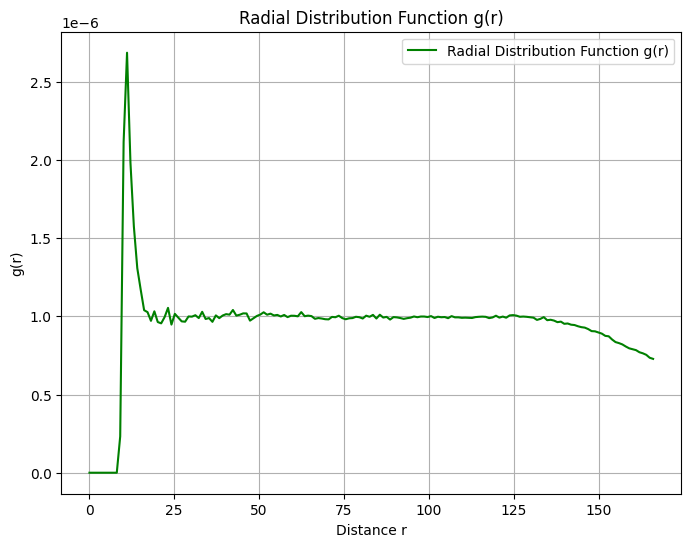

In [ ]:
# Step 3: Run NpT simulation (with volume fluctuations)
steps = 1000000  # Number of steps for NpT

volumes_gas, final_positions, final_repulsion_energy, final_attraction_energy = run_simulation(
    steps, positions, L, V, epsilon, sigma, beta, betaP, repulsion_energy, attraction_energy, N)

# Liquid Phase - Simulation

In [ ]:
# Liquid phase
N = 1000 # Number of particles
V = N / 0.74 # Liquid phase
L = V ** (1/3)

In [ ]:
# Step 1: Initialize particle positions
positions = initialize_positions(N, L)

In [ ]:
# Step 2: Run NVT equilibration
equilibration_steps = 1000000  # Number of steps for NVT equilibration
positions, repulsion_energy, attraction_energy, energy_values_liquid = run_nvt_equilibration(
    equilibration_steps, positions, L, epsilon, sigma, beta)

Step 0, Volume: 1351.3513513513515, Total Energy: -5526.3670706420735, Time Elapsed: 10.94 seconds
Step 10000, Volume: 1293.8765833796342, Total Energy: -5555.5939375480975, Time Elapsed: 13.66 seconds
Step 20000, Volume: 1325.8077642715796, Total Energy: -5548.781053059062, Time Elapsed: 16.01 seconds
Step 30000, Volume: 1299.3631930248746, Total Energy: -5596.932711341899, Time Elapsed: 18.36 seconds
Step 40000, Volume: 1359.3043393839366, Total Energy: -5536.78932185389, Time Elapsed: 20.73 seconds
Step 50000, Volume: 1333.3417535979793, Total Energy: -5550.629845616594, Time Elapsed: 23.67 seconds
Step 60000, Volume: 1303.6566297397867, Total Energy: -5560.370134872586, Time Elapsed: 26.50 seconds
Step 70000, Volume: 1297.165192581536, Total Energy: -5572.007219929913, Time Elapsed: 28.86 seconds
Step 80000, Volume: 1324.3312752639545, Total Energy: -5576.176746043384, Time Elapsed: 31.26 seconds
Step 90000, Volume: 1309.6685068044308, Total Energy: -5652.397820094527, Time Elapsed

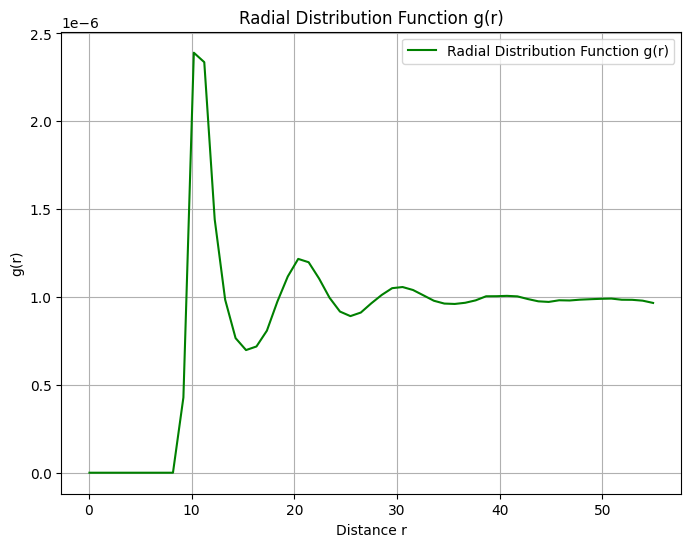

In [ ]:
# Step 3: Run NpT simulation (with volume fluctuations)
steps = 1000000  # Number of steps for NpT

volumes_liquid, final_positions, final_repulsion_energy, final_attraction_energy = run_simulation(
    steps, positions, L, V, epsilon, sigma, beta, betaP, repulsion_energy, attraction_energy, N)

# Plot the equilibration step (Energy)

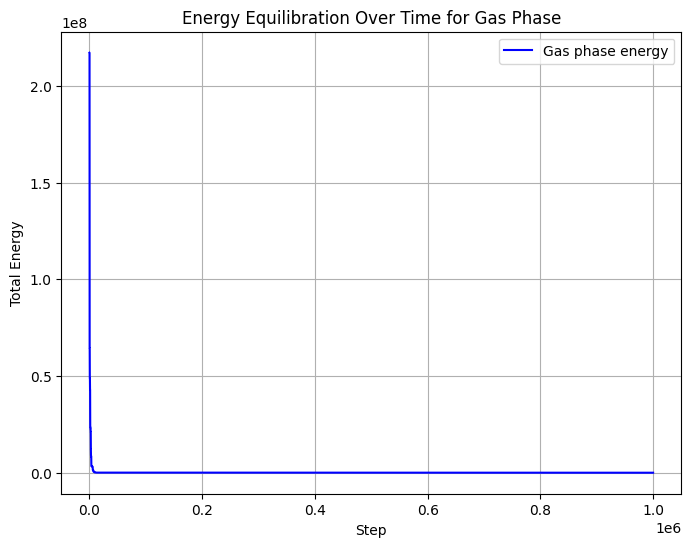

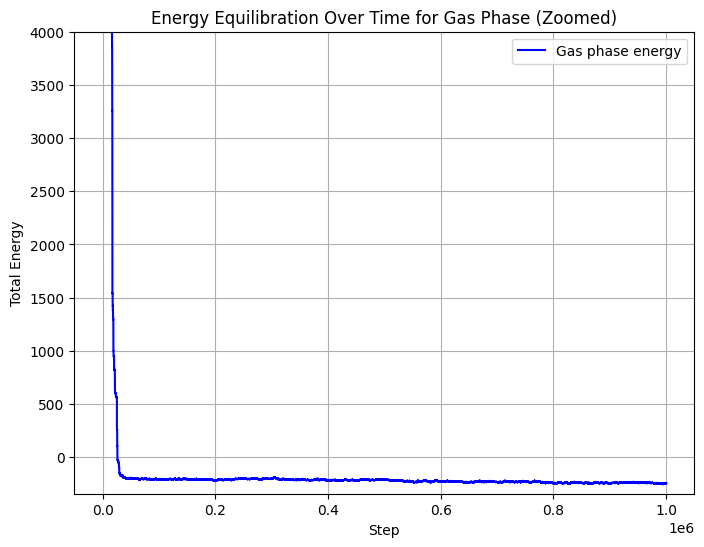

In [ ]:
plt.figure(figsize=(8, 6))

# Plot energy values for gas
plt.plot(range(equilibration_steps), energy_values_gas, label='Gas phase energy', color='blue')

plt.xlabel('Step')
plt.ylabel('Total Energy')
plt.title('Energy Equilibration Over Time for Gas Phase')
plt.legend()
plt.grid(True)
plt.show()

print('\n')

plt.figure(figsize=(8, 6))

# Plot energy values for gas zoomed
plt.plot(range(equilibration_steps), energy_values_gas, label='Gas phase energy', color='blue')

plt.ylim(energy_values_gas[-1] - 100, 4000)
plt.xlabel('Step')
plt.ylabel('Total Energy')
plt.title('Energy Equilibration Over Time for Gas Phase (Zoomed)')
plt.legend()
plt.grid(True)
plt.show()

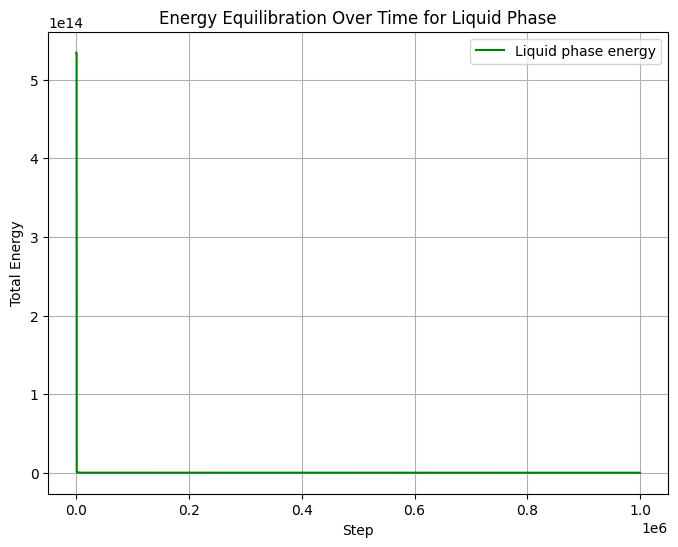

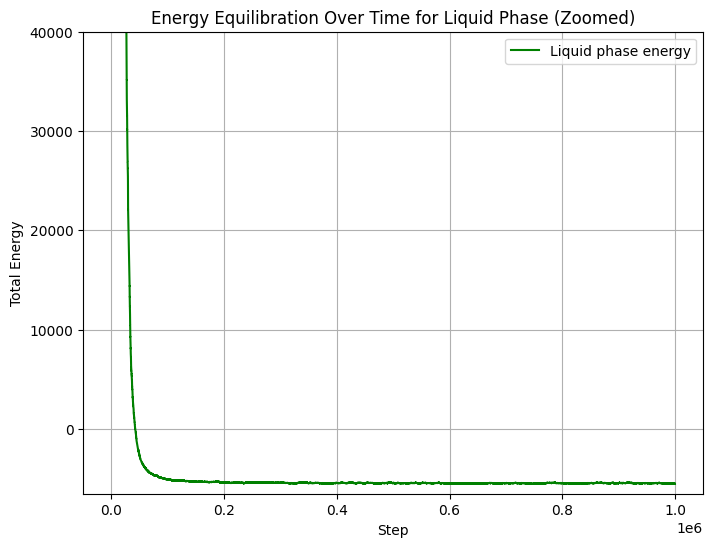

In [ ]:
# Plot energy values for liquid
plt.figure(figsize=(8, 6))
plt.plot(range(equilibration_steps), energy_values_liquid, label='Liquid phase energy', color='green')
plt.xlabel('Step')
plt.ylabel('Total Energy')
plt.title('Energy Equilibration Over Time for Liquid Phase')

plt.legend()
plt.grid(True)
plt.show()

print('\n')

# Plot energy values for liquid
plt.figure(figsize=(8, 6))
plt.plot(range(equilibration_steps), energy_values_liquid, label='Liquid phase energy', color='green')
plt.ylim(energy_values_liquid[-1] - 1000, 40000)
plt.xlabel('Step')
plt.ylabel('Total Energy')
plt.title('Energy Equilibration Over Time for Liquid Phase (Zoomed)')

plt.legend()
plt.grid(True)
plt.show()

# Plot Volume Distribution

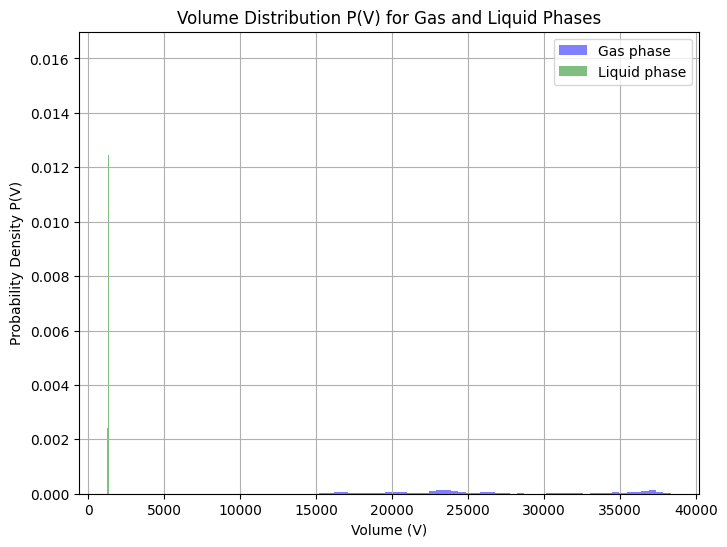

In [ ]:
plt.figure(figsize=(8, 6))

# Plot histogram for gas phase volumes
plt.hist(volumes_gas, bins=50, density=True, alpha=0.5, label='Gas phase', color='blue')

# Plot histogram for liquid phase volumes
plt.hist(volumes_liquid, bins=50, density=True, alpha=0.5, label='Liquid phase', color='green')

# Plot labels and legend
#plt.ylim(0, 0.015) # for both
plt.xlabel('Volume (V)')
plt.ylabel('Probability Density P(V)')
#plt.title('Volume Distribution P(V) for Gas Phase')
#plt.title('Volume Distribution P(V) for Liquid Phase')
plt.title('Volume Distribution P(V) for Gas and Liquid Phases')
plt.legend()
plt.grid(True)
plt.show()

# Plot Density Distribution

In [ ]:
# Step 4: Plot the density distribution function
densities_gas = densities_and_average_volume(volumes_gas, N)
densities_liquid = densities_and_average_volume(volumes_liquid, N)

<1/V>: 3.967932468390828e-05
1/<V>: 3.686453808130088e-05
<1/V>: 0.000769503670429654
1/<V>: 0.0007692870460574708


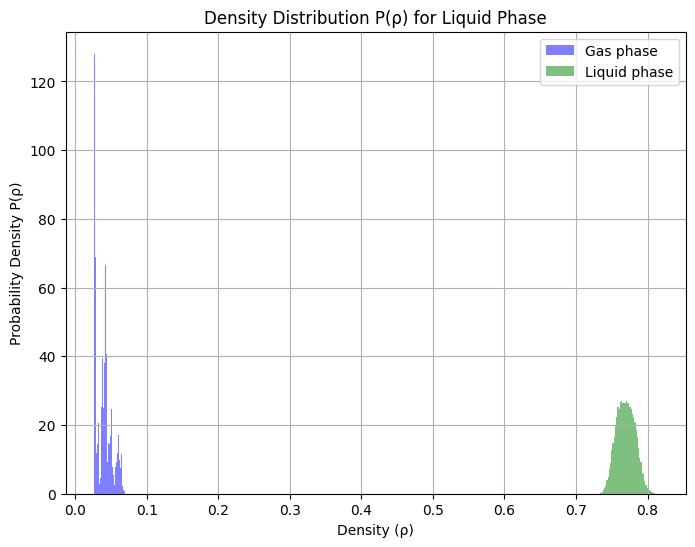

In [ ]:
plt.figure(figsize=(8, 6))

# Plot histogram for gas phase densities
plt.hist(densities_gas, bins=50, density=True, alpha=0.5, label='Gas phase', color='blue')

# Plot histogram for liquid phase densities
plt.hist(densities_liquid, bins=50, density=True, alpha=0.5, label='Liquid phase', color='green')

# Plot labels and legend
plt.xlabel('Density (ρ)')
plt.ylabel('Probability Density P(ρ)')
#plt.title('Density Distribution P(ρ) for Gas Phase')
plt.title('Density Distribution P(ρ) for Liquid Phase')
#plt.title('Density Distribution P(ρ) for Gas and Liquid Phases')

# Add legend and grid
plt.legend()
plt.grid(True)

plt.show()

# Gas phase with different N = 10, 100 -> Plot density distributions

# N = 100

In [ ]:
N = 100 # Number of particles
# Gas phase
V = N / 0.027 # Gas phase
L = V ** (1/3)

In [ ]:
# Step 1: Initialize particle positions
positions = initialize_positions(N, L)

In [ ]:
# Step 2: Run NVT equilibration
equilibration_steps = 1000000  # Number of steps for NVT equilibration
positions, repulsion_energy, attraction_energy, energy_values_100 = run_nvt_equilibration(
    equilibration_steps, positions, L, epsilon, sigma, beta)

Step 0, Volume: 3703.703703703704, Total Energy: -25.130455582194678, Time Elapsed: 0.19 seconds
Step 10000, Volume: 3552.680728850154, Total Energy: -26.014044869530462, Time Elapsed: 1.87 seconds
Step 20000, Volume: 3197.5209320044146, Total Energy: -31.68431666596116, Time Elapsed: 3.35 seconds
Step 30000, Volume: 3903.7315930000145, Total Energy: -27.648008759756475, Time Elapsed: 4.82 seconds
Step 40000, Volume: 3382.704710255647, Total Energy: -34.02527604027682, Time Elapsed: 6.30 seconds
Step 50000, Volume: 4058.0981654497014, Total Energy: -25.71211856881127, Time Elapsed: 7.76 seconds
Step 60000, Volume: 3105.5538300768144, Total Energy: -32.16224759212981, Time Elapsed: 9.24 seconds
Step 70000, Volume: 3638.8062338703016, Total Energy: -26.93144519159974, Time Elapsed: 10.79 seconds
Step 80000, Volume: 2929.8390632150495, Total Energy: -30.152932317133278, Time Elapsed: 13.01 seconds
Step 90000, Volume: 2613.497243820752, Total Energy: -38.00399023401624, Time Elapsed: 14.55

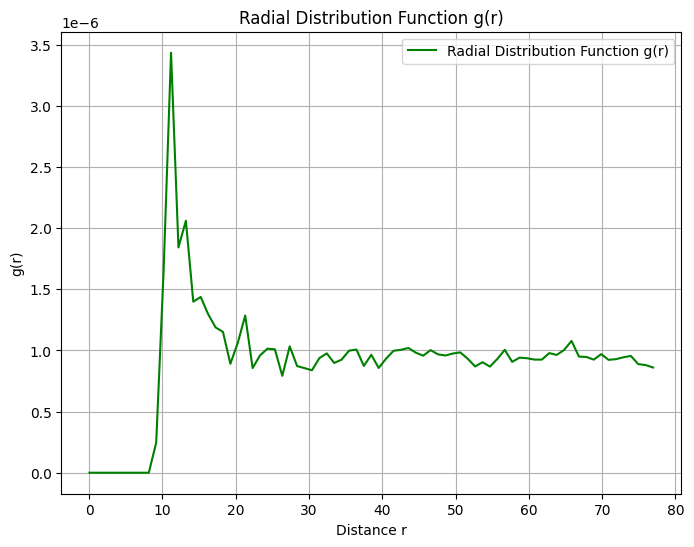

In [ ]:
# Step 3: Run NpT simulation (with volume fluctuations)
steps = 1000000  # Number of steps for NpT

volumes_100, final_positions, final_repulsion_energy, final_attraction_energy = run_simulation(
    steps, positions, L, V, epsilon, sigma, beta, betaP, repulsion_energy, attraction_energy, N)

# N = 10


In [ ]:
N = 10 # Number of particles
# Gas phase
V = N / 0.027 # Gas phase
L = V ** (1/3)

In [ ]:
# Step 1: Initialize particle positions
positions = initialize_positions(N, L)

In [ ]:
# Step 2: Run NVT equilibration
equilibration_steps = 1000000  # Number of steps for NVT equilibration
positions, repulsion_energy, attraction_energy, energy_values_10 = run_nvt_equilibration(
    equilibration_steps, positions, L, epsilon, sigma, beta)

Step 0, Volume: 370.3703703703704, Total Energy: -2.484227997741413, Time Elapsed: 0.00 seconds
Step 10000, Volume: 408.44360183807294, Total Energy: -3.425426129556058, Time Elapsed: 1.38 seconds
Step 20000, Volume: 49.85269792226775, Total Energy: -11.172005643480377, Time Elapsed: 2.73 seconds
Step 30000, Volume: 357.0766564387393, Total Energy: -1.367373658804178, Time Elapsed: 4.08 seconds
Step 40000, Volume: 451.1051878553669, Total Energy: -2.167330321301963, Time Elapsed: 5.43 seconds
Step 50000, Volume: 674.0729070180331, Total Energy: -0.35397489906017515, Time Elapsed: 7.21 seconds
Step 60000, Volume: 376.6276766214678, Total Energy: -2.9673102841916226, Time Elapsed: 8.87 seconds
Step 70000, Volume: 254.652855279565, Total Energy: -3.4090904452904547, Time Elapsed: 10.20 seconds
Step 80000, Volume: 242.1265119229405, Total Energy: -2.922340868215791, Time Elapsed: 11.57 seconds
Step 90000, Volume: 358.40317215183154, Total Energy: -4.028324502543006, Time Elapsed: 12.93 sec

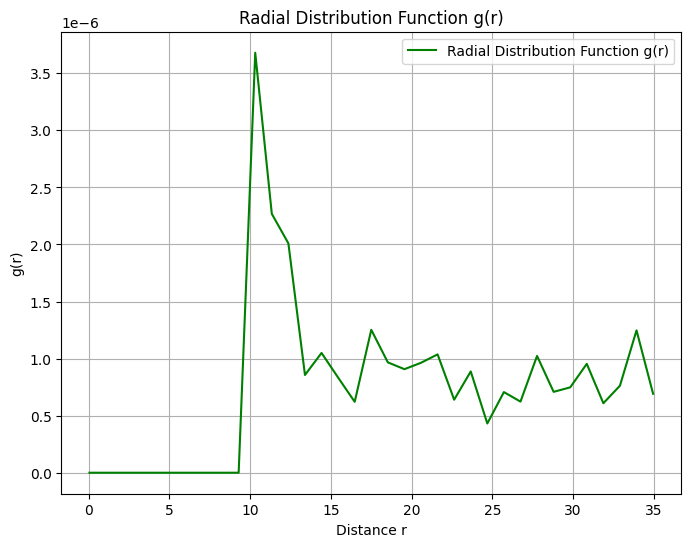

In [ ]:
# Step 3: Run NpT simulation (with volume fluctuations)
steps = 1000000  # Number of steps for NpT

volumes_10, final_positions, final_repulsion_energy, final_attraction_energy = run_simulation(
    steps, positions, L, V, epsilon, sigma, beta, betaP, repulsion_energy, attraction_energy, N)

Plot Density Distribution

In [ ]:
# Step 4: Plot the density distribution function
densities_100 = densities_and_average_volume(volumes_100, N)
densities_10 = densities_and_average_volume(volumes_10, N)

<1/V>: 0.00030787072262134256
1/<V>: 0.0002961018800533434
<1/V>: 0.0030675226895984183
1/<V>: 0.0024581391817272554


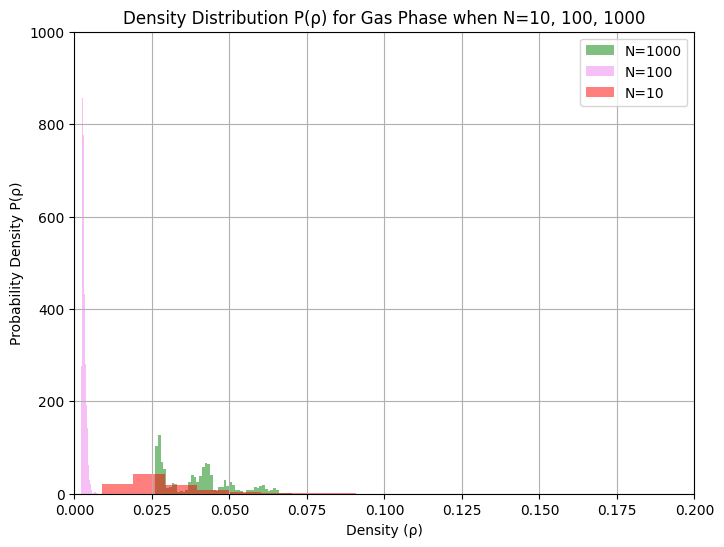

In [ ]:
plt.figure(figsize=(8, 6))

# Plot histogram for densities
plt.hist(densities_gas, bins=50, density=True, alpha=0.5, label='N=1000', color='green')
plt.hist(densities_100, bins=50, density=True, alpha=0.5, label='N=100', color='violet')
plt.hist(densities_10, bins=50, density=True, alpha=0.5, label='N=10', color='red')

# Plot labels and legend
plt.ylim(0, 1200)
#plt.xlim(0,0.2)
plt.xlabel('Density (ρ)')
plt.ylabel('Probability Density P(ρ)')
plt.title('Density Distribution P(ρ) for Gas Phase when N=10, 100, 1000')


# Add legend and grid
plt.legend()
plt.grid(True)

plt.show()

# Gas phase with N=100 and pressure 40 times bigger -> Transitions -> Plot density distribution

In [ ]:
# Gas phase
N = 100
V = N / 0.027 # Gas phase
L = V ** (1/3)
betaP = 0.023 * 40

In [ ]:
# Step 1: Initialize particle positions
positions = initialize_positions(N, L)

In [ ]:
# Step 2: Run NVT equilibration
equilibration_steps = 1000000  # Number of steps for NVT equilibration
positions, repulsion_energy, attraction_energy, energy_values = run_nvt_equilibration(
    equilibration_steps, positions, L, epsilon, sigma, beta)

Step 0, Volume: 3703.703703703704, Total Energy: -25.782070248892055, Time Elapsed: 0.10 seconds
Step 10000, Volume: 670.8860870427229, Total Energy: -103.20886237650916, Time Elapsed: 1.58 seconds
Step 20000, Volume: 240.00711999377302, Total Energy: -288.6261375890406, Time Elapsed: 3.03 seconds
Step 30000, Volume: 180.77628586016277, Total Energy: -385.9045869865052, Time Elapsed: 4.50 seconds
Step 40000, Volume: 163.19025884594672, Total Energy: -443.4490351136893, Time Elapsed: 5.96 seconds
Step 50000, Volume: 140.13364984253673, Total Energy: -499.4598480477388, Time Elapsed: 7.44 seconds
Step 60000, Volume: 131.67271886006594, Total Energy: -522.3954463567876, Time Elapsed: 9.15 seconds
Step 70000, Volume: 126.6139685471558, Total Energy: -557.7908238193609, Time Elapsed: 11.24 seconds
Step 80000, Volume: 133.57627305046117, Total Energy: -544.952687197575, Time Elapsed: 12.73 seconds
Step 90000, Volume: 128.89494483592853, Total Energy: -555.2626810793562, Time Elapsed: 14.18 s

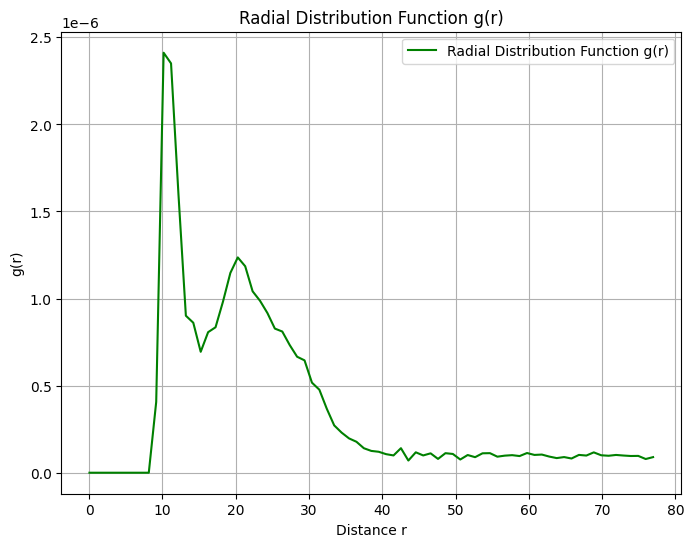

In [ ]:
# Step 3: Run NpT simulation (with volume fluctuations)
steps = 1000000  # Number of steps for NpT

volumes_transition, final_positions, final_repulsion_energy, final_attraction_energy = run_simulation(
    steps, positions, L, V, epsilon, sigma, beta, betaP, repulsion_energy, attraction_energy, N)

In [ ]:
# Step 4: Plot the density distribution function
densities_transition = densities_and_average_volume(volumes_transition, N)

<1/V>: 0.00771867511244515
1/<V>: 0.0067944732756742305


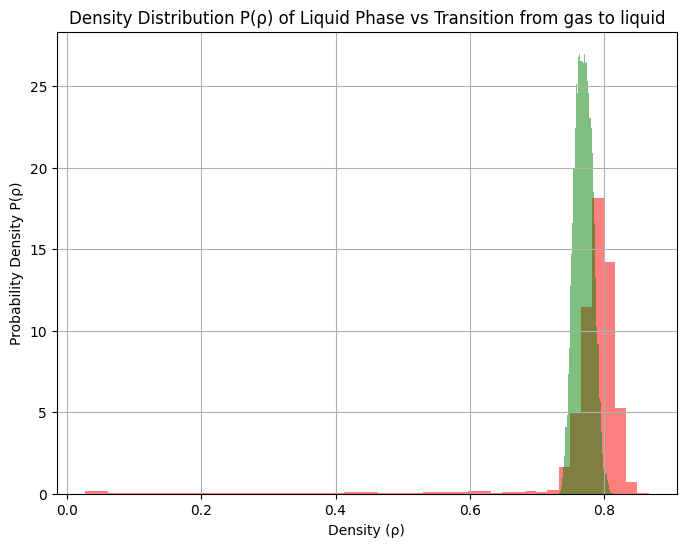

In [ ]:
plt.figure(figsize=(8, 6))

# Plot histogram for densities
plt.hist(densities_transition, bins=50, density=True, alpha=0.5, label='Transition gas->liquid', color='red')

plt.hist(densities_liquid, bins=50, density=True, alpha=0.5, label='Liquid phase', color='green')

# Plot labels and legend
plt.xlabel('Density (ρ)')
plt.ylabel('Probability Density P(ρ)')
plt.title('Density Distribution P(ρ) of Liquid Phase vs Transition from gas to liquid')
#plt.title('Density Distribution P(ρ) of Transition from gas to liquid')


# Add grid
plt.grid(True)
plt.show()

# Simulation for N = 1000, T_star = 1.32 and pressure = 0.0923 -> Plot volume distribution

In [ ]:
# Gas phase
N=1000
V = N / 0.027 # Gas phase
L = V ** (1/3)
betaP = 0.0923
T_star = 1.29
beta = 1 / (kB * T_star)
epsilon = 1/1.29

In [ ]:
# Step 1: Initialize particle positions
positions = initialize_positions(N, L)

In [ ]:
# Step 2: Run NVT equilibration
equilibration_steps = 1000000  # Number of steps for NVT equilibration
positions, repulsion_energy, attraction_energy, energy_values_temp = run_nvt_equilibration(
    equilibration_steps, positions, L, epsilon, sigma, beta)

Step 0, Volume: 37037.03703703704, Total Energy: -144.5948713619495, Time Elapsed: 11.26 seconds
Step 10000, Volume: 32206.623184616015, Total Energy: -162.38370298896535, Time Elapsed: 13.61 seconds
Step 20000, Volume: 29505.192318738867, Total Energy: -175.69584634290584, Time Elapsed: 15.95 seconds
Step 30000, Volume: 27469.060992521874, Total Energy: -189.15465114994993, Time Elapsed: 18.26 seconds
Step 40000, Volume: 24303.75313839135, Total Energy: -202.72268347575735, Time Elapsed: 20.86 seconds
Step 50000, Volume: 22687.32756483875, Total Energy: -215.3703352997398, Time Elapsed: 23.91 seconds
Step 60000, Volume: 21174.262475490217, Total Energy: -244.95402675294417, Time Elapsed: 26.24 seconds
Step 70000, Volume: 20636.98256626972, Total Energy: -244.9099769574107, Time Elapsed: 28.54 seconds
Step 80000, Volume: 19261.576454484195, Total Energy: -267.8538108733858, Time Elapsed: 30.87 seconds
Step 90000, Volume: 18012.08034204767, Total Energy: -284.3492947846137, Time Elapsed

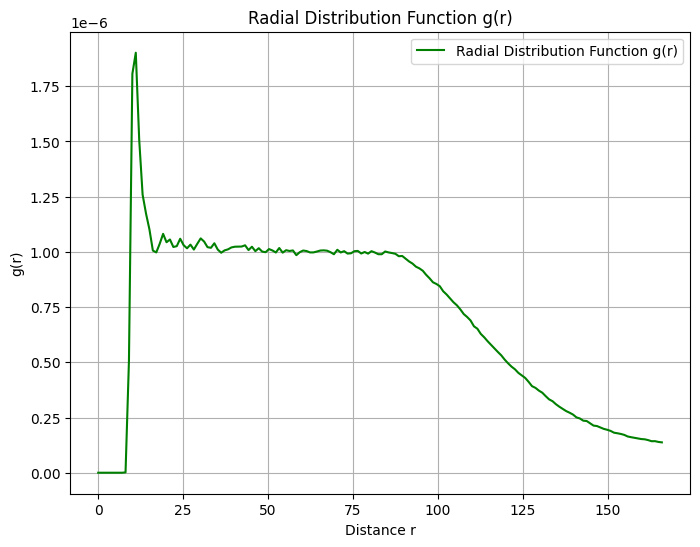

In [ ]:
# Step 3: Run NpT simulation (with volume fluctuations)
steps = 1000000  # Number of steps for NpT

volumes_temp, final_positions, final_repulsion_energy, final_attraction_energy = run_simulation(
    steps, positions, L, V, epsilon, sigma, beta, betaP, repulsion_energy, attraction_energy, N)

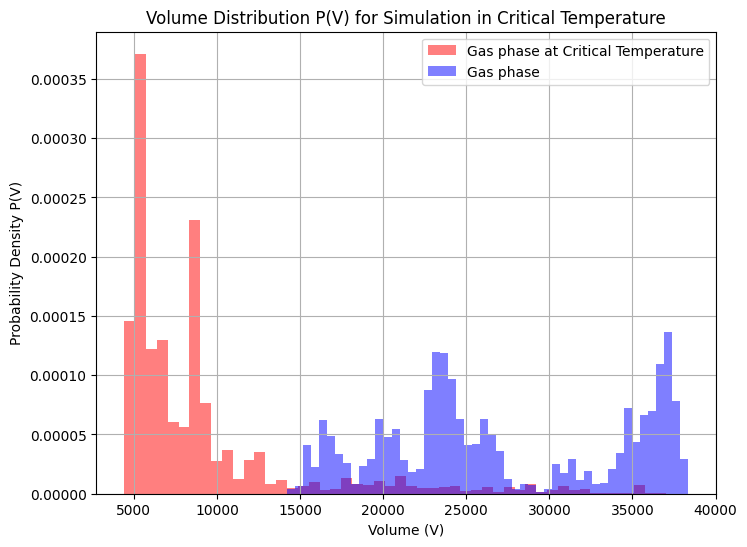

In [ ]:
plt.figure(figsize=(8, 6))

# Plot histogram for gas phase volumes
plt.hist(volumes_temp, bins=50, density=True, alpha=0.5, label='Gas phase at Critical Temperature', color='red')

plt.hist(volumes_gas, bins=50, density=True, alpha=0.5, label='Gas phase', color='blue')

#plt.hist(volumes_liquid, bins=50, density=True, alpha=0.5, label='Liquid phase', color='green')

# Plot labels and legend
#plt.ylim(0, 0.009)
plt.xlabel('Volume (V)')
plt.ylabel('Probability Density P(V)')
plt.title('Volume Distribution P(V) for Simulation in Critical Temperature')
plt.legend()
plt.grid(True)
plt.show()